In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stars-data/IMG_3060.HEIC
/kaggle/input/stars-data/IMG_3058.HEIC
/kaggle/input/stars-data/IMG_3053.HEIC
/kaggle/input/stars-data/ST_db2_edited.png
/kaggle/input/stars-data/ST_db1.png
/kaggle/input/stars-data/IMG_3059.HEIC
/kaggle/input/stars-data/IMG_3061.HEIC
/kaggle/input/stars-data/IMG_3062.HEIC
/kaggle/input/stars-data/IMG_3055 (1).HEIC
/kaggle/input/stars-data/IMG_3055.HEIC
/kaggle/input/stars-data/ST_db1_edited.png
/kaggle/input/stars-data/IMG_3054 (1).HEIC
/kaggle/input/stars-data/ST_db2.png
/kaggle/input/stars-data/IMG_3056.HEIC
/kaggle/input/stars-data/IMG_3054.HEIC


In [35]:
!pip install pillow-heif


In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from scipy.spatial import distance
import networkx as nx
import pandas as pd
from numpy.linalg import norm
from collections import Counter
from astropy.io import fits
from PIL import Image
from pathlib import Path
from skimage.feature import blob_log
import pillow_heif
import math
from math import acos, degrees
from scipy.spatial import cKDTree
from numpy.linalg import svd
from itertools import combinations

In [37]:


# --- HEIC support ---
pillow_heif.register_heif_opener()


def load_heic_grayscale(path: str) -> np.ndarray:
    """Load a HEIC image and convert to grayscale numpy array."""
    img = Image.open(path)
    return np.array(img.convert('L'))

def detect_stars_heic(input_path: str, csv_path: str):
    # 1) Load & convert to gray
    gray = load_heic_grayscale(input_path)

    # 2) Blur + binary threshold
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, bw = cv2.threshold(
        blur,
        blur.mean() * 1.5,
        255,
        cv2.THRESH_BINARY
    )

    # 3) Connected components
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(
        bw.astype(np.uint8),
        connectivity=8
    )
    print(f"{Path(input_path).name}: {num-1} raw blobs")

    # 4) Filter each component into a star
    stars = []
    for i in range(1, num):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < 20 or area > 5000:        # tweak these to your PSF size
            continue
        id = len(stars)
        x, y = centroids[i]
        r    = int(math.sqrt(area / np.pi))
        b    = float(gray[labels == i].mean())

        stars.append({'id': id ,'x': x, 'y': y, 'r': r, 'b': b})

    # 5) Save to CSV
    pd.DataFrame(stars).to_csv(csv_path, index=False)
    print(f"⭑ {Path(input_path).name}: {len(stars)} stars → {Path(csv_path).name}")


def detect_stars_cv2(
    input_path: str,
    csv_path: str,
    threshold: float = 0.02,
    min_sigma: float = 2,
    max_sigma: float = 30,
    num_sigma: int = 10
):
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Unable to read {input_path}")
        return
    blobs = blob_log(img, threshold=threshold,
                     min_sigma=min_sigma, max_sigma=max_sigma,
                     num_sigma=num_sigma)
    blobs[:, 2] *= np.sqrt(2)
    
    H, W = img.shape
    stars = []
    for y, x, r in blobs:
        yy, xx = np.ogrid[:H, :W]
        mask = (yy - y)**2 + (xx - x)**2 <= r**2
        if not mask.any():
            continue
        brightness = float(img[mask].mean())
        stars.append({'x': float(x), 'y': float(y),
                      'b': brightness, 'r': float(r)})
    pd.DataFrame(stars).to_csv(csv_path, index=False)
    print(f"⭑ {Path(input_path).name}: {len(stars)} stars → {Path(csv_path).name}")


input_dir  = "/kaggle/input/stars-data"
output_dir = "output_csv"
os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(input_dir):
    in_path = os.path.join(input_dir, fname)
    stem    = Path(fname).stem
    out_csv = os.path.join(output_dir, f"{stem}.csv")
    
    ext = fname.lower().rsplit('.', 1)[-1]
    if ext in ("heic",):
        detect_stars_heic(in_path, out_csv)
    elif ext in ("png", "jpg", "jpeg", "tif", "tiff"):
        detect_stars_cv2(in_path, out_csv)
    else:
        print(f"— Skipping unsupported file: {fname}")

print("✅ All done! CSV files are in:", output_dir)

IMG_3060.HEIC: 3399 raw blobs
⭑ IMG_3060.HEIC: 67 stars → IMG_3060.csv
IMG_3058.HEIC: 13 raw blobs
⭑ IMG_3058.HEIC: 10 stars → IMG_3058.csv
IMG_3053.HEIC: 19 raw blobs
⭑ IMG_3053.HEIC: 6 stars → IMG_3053.csv
⭑ ST_db2_edited.png: 42 stars → ST_db2_edited.csv
⭑ ST_db1.png: 756 stars → ST_db1.csv
IMG_3059.HEIC: 17 raw blobs
⭑ IMG_3059.HEIC: 15 stars → IMG_3059.csv
IMG_3061.HEIC: 2086 raw blobs
⭑ IMG_3061.HEIC: 65 stars → IMG_3061.csv
IMG_3062.HEIC: 10073 raw blobs
⭑ IMG_3062.HEIC: 1673 stars → IMG_3062.csv
IMG_3055 (1).HEIC: 395 raw blobs
⭑ IMG_3055 (1).HEIC: 28 stars → IMG_3055 (1).csv
IMG_3055.HEIC: 395 raw blobs
⭑ IMG_3055.HEIC: 28 stars → IMG_3055.csv
⭑ ST_db1_edited.png: 68 stars → ST_db1_edited.csv
IMG_3054 (1).HEIC: 374 raw blobs
⭑ IMG_3054 (1).HEIC: 29 stars → IMG_3054 (1).csv
⭑ ST_db2.png: 811 stars → ST_db2.csv
IMG_3056.HEIC: 76144 raw blobs
⭑ IMG_3056.HEIC: 5052 stars → IMG_3056.csv
IMG_3054.HEIC: 374 raw blobs
⭑ IMG_3054.HEIC: 29 stars → IMG_3054.csv
✅ All done! CSV files are 

In [38]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import pillow_heif

# Register HEIC opener
pillow_heif.register_heif_opener()

def visualize_and_save_stars(image_path: str, csv_path: str, output_path: str):
    # load star table
    df = pd.read_csv(csv_path)
    # load the image (HEIC via pillow_heif or any other via OpenCV)
    ext = image_path.lower().rsplit('.',1)[-1]
    if ext == 'heic':
        pil = Image.open(image_path).convert('RGB')
        img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(image_path)
    # draw
    for _, row in df.iterrows():
        x, y, r = int(row.x), int(row.y), int(row.r)
        cv2.circle(img, (x,y), r, (0,255,0), 2)
        cv2.circle(img, (x,y), 2, (0,0,255), -1)
    cv2.imwrite(output_path, img)
    print("Wrote", output_path)

os.makedirs("annotated_images", exist_ok=True)
for fname in os.listdir("/kaggle/input/stars-data"):
    stem, ext = os.path.splitext(fname)
    if ext.lower().lstrip('.') in ("heic","jpg","jpeg","png"):
        inp = f"/kaggle/input/stars-data/{fname}"
        csv = f"output_csv/{stem}.csv"
        out = f"annotated_images/{stem}_annotated.jpg"
        if os.path.exists(csv):
            visualize_and_save_stars(inp, csv, out)
        else:
            print("No CSV for", fname)

def batch_annotate(input_dir: str, csv_dir: str, output_dir: str):
    """
    Loops over all images in input_dir, finds corresponding CSVs in csv_dir,
    annotates and saves to output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        stem, ext = os.path.splitext(fname)
        ext = ext.lower().lstrip('.')
        if ext not in ("heic", "png", "jpg", "jpeg", "tif", "tiff"):
            continue
        image_path = os.path.join(input_dir, fname)
        csv_path   = os.path.join(csv_dir, f"{stem}.csv")
        if not os.path.exists(csv_path):
            print(f"⚠️ Missing CSV for {fname}, expected {csv_path}")
            continue
        output_path = os.path.join(output_dir, f"{stem}_annotated.jpg")
        visualize_and_save_stars(image_path, csv_path, output_path)


Wrote annotated_images/IMG_3060_annotated.jpg
Wrote annotated_images/IMG_3058_annotated.jpg
Wrote annotated_images/IMG_3053_annotated.jpg
Wrote annotated_images/ST_db2_edited_annotated.jpg
Wrote annotated_images/ST_db1_annotated.jpg
Wrote annotated_images/IMG_3059_annotated.jpg
Wrote annotated_images/IMG_3061_annotated.jpg
Wrote annotated_images/IMG_3062_annotated.jpg
Wrote annotated_images/IMG_3055 (1)_annotated.jpg
Wrote annotated_images/IMG_3055_annotated.jpg
Wrote annotated_images/ST_db1_edited_annotated.jpg
Wrote annotated_images/IMG_3054 (1)_annotated.jpg
Wrote annotated_images/ST_db2_annotated.jpg
Wrote annotated_images/IMG_3056_annotated.jpg
Wrote annotated_images/IMG_3054_annotated.jpg


Found 1565 matching triangles.
Wrote 28 matched stars → matched_stars.csv


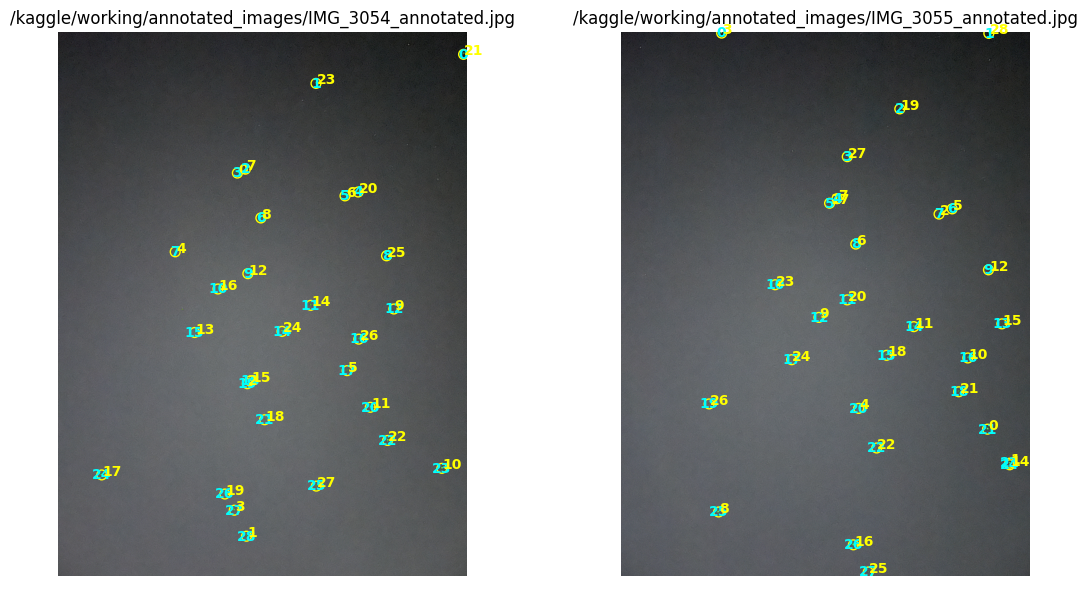

In [47]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
from collections import Counter

# Compute triangle angles
def triangle_angles(pts, tri):
    i, j, k = tri
    a, b, c = pts[i], pts[j], pts[k]
    def angle(p, q, r):
        v1 = np.array(q) - np.array(p)
        v2 = np.array(r) - np.array(p)
        dot = np.dot(v1, v2)
        norm = np.linalg.norm(v1) * np.linalg.norm(v2)
        if norm == 0:
            return None
        return math.degrees(math.acos(np.clip(dot / norm, -1, 1)))
    A = angle(a, b, c)
    B = angle(b, a, c)
    C = angle(c, a, b)
    if None in (A, B, C):
        return None
    return sorted([A, B, C])

# ── USER CONFIG ───────────────────────────────────────────────────────────
star_csv1      = "/kaggle/working/output_csv/IMG_3054.csv"
star_csv2      = "/kaggle/working/output_csv/IMG_3055.csv"
image1_jpg     = "/kaggle/working/annotated_images/IMG_3054_annotated.jpg"
image2_jpg     = "/kaggle/working/annotated_images/IMG_3055_annotated.jpg"
angle_thresh  = 0.2  # degrees tolerance per angle
output_match_csv = "matched_stars.csv"
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load star coords
df1 = pd.read_csv(star_csv1)
df2 = pd.read_csv(star_csv2)
pts1 = df1[['x','y']].values.tolist()
pts2 = df2[['x','y']].values.tolist()

# 2) Enumerate triangles and compute angles
tris1 = list(itertools.combinations(range(len(pts1)), 3))
tris2 = list(itertools.combinations(range(len(pts2)), 3))
angles1 = [(tri, triangle_angles(pts1, tri)) for tri in tris1]
angles2 = [(tri, triangle_angles(pts2, tri)) for tri in tris2]

# 3) Match triangles by angle
matched_tris = []
for tri1, ang1 in angles1:
    if not ang1:
        continue
    for tri2, ang2 in angles2:
        if not ang2:
            continue
        if all(abs(ang1[i] - ang2[i]) <= angle_thresh for i in range(3)):
            matched_tris.append((tri1, tri2))

print(f"Found {len(matched_tris)} matching triangles.")

# 4) Count star frequencies in matches
ctr1 = Counter()
ctr2 = Counter()
for tri1, tri2 in matched_tris:
    ctr1.update(tri1)
    ctr2.update(tri2)

# 5) Rank and pair stars
ranked1 = [idx for idx, _ in ctr1.most_common()]
ranked2 = [idx for idx, _ in ctr2.most_common()]
k = min(len(ranked1), len(ranked2))
pairs = [(ranked1[i], ranked2[i]) for i in range(k)]

# 6) Write match CSV
with open(output_match_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id1','count1','id2','count2'])
    for i1, i2 in pairs:
        writer.writerow([i1, ctr1[i1], i2, ctr2[i2]])
print(f"Wrote {len(pairs)} matched stars → {output_match_csv}")

# 7) Visualize all matched stars, showing both IDs
img1 = cv2.imread(image1_jpg)
img2 = cv2.imread(image2_jpg)
if img1 is None or img2 is None:
    print("Cannot load annotated images for visualization.")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); ax1.axis('off')
    ax1.set_title(image1_jpg)
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); ax2.axis('off')
    ax2.set_title(image2_jpg)

    n_show = len(df1)
    for i1, i2 in pairs[:n_show]:
        x1, y1 = pts1[i1]
        x2, y2 = pts2[i2]

        # draw circles
        ax1.scatter(x1, y1, s=50, facecolors='none', edgecolors='yellow', lw=1)
        ax2.scatter(x2, y2, s=50, facecolors='none', edgecolors='yellow', lw=1)
        
        
        ax1.text(x1,   y1,   str(i1),
                 color='cyan', fontsize=10, weight='bold',
                 va='center', ha='center')
        ax2.text(x2,   y2,   str(i2),
                 color='cyan', fontsize=10, weight='bold',
                 va='center', ha='center')

        # label *matched* star ID in yellow (offset slightly)
        ax1.text(x1+5, y1+5, str(i2),
                 color='yellow', fontsize=10, weight='bold')
        ax2.text(x2+5, y2+5, str(i1),
                 color='yellow', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.show()

